## Magnificent 7 Backtesting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

### 1.Download stock price from yahoo finance

In [2]:
# stocks
tickers = ['MSFT', 'AAPL', 'NVDA', 'AMZN', 'GOOGL', 'META', 'TSLA'] 
# date
start = "2013-01-01"
end = "2023-12-31"

for ticker in tickers:
# get the price data for each stock
    data = yf.download(ticker, start = start, end = end)[['Open','High','Low','Close','Volume']]
    data.to_csv(f'data/{ticker}.csv', index = True)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### 2. Indicator

Here we build the structure of **Double Bollinger Band Indicator**.

Set up the time period to 20 days, and use $2\sigma$ as boundaries.

If the price goes beyond the boundaries, we also assume the signal equals to 0 because of the high volatility which indicates the risk.

In [5]:
def Double_Bollinger_Band_Indicator(data, period=20):
    signals = pd.DataFrame(index=data.index)
    signals['signal'] = 0.0

    # moving average
    SMA = data['Close'].rolling(window=period).mean().fillna(0)
    # standard deviation
    std = data['Close'].rolling(window=period).std().fillna(0)

    # calculate upper and lower bands
    upper_2 = SMA + 2 * std
    lower_2 = SMA - 2 * std
    upper_1 = SMA + std
    lower_1 = SMA - std

    # buy signal:
    signals.loc[(data['Close'] > upper_1) & (data['Close'] <= upper_2), 'signal'] = 1.0
    # sell signal
    signals.loc[(data['Close'] < lower_1) & (data['Close'] >= lower_2), 'signal'] = -1.0
    # neutral
    signals.loc[(data['Close'] <= upper_1) & (data['Close'] >= lower_1), 'signal'] = 0.0

    return signals['signal']

### 3. Performance Metrics

Set a fixed risk-free rate $r =0.03$ to simplify calculation.

In [6]:
# metrics calculation
def calculate_daily_returns(portfolio_value):
    daily_returns = portfolio_value.pct_change()
    return daily_returns

# total return
def calculate_total_return(portfolio_value):
    total_return = portfolio_value.iloc[-1] / portfolio_value.iloc[0] - 1
    return total_return

# annual Return
def calculate_annual_return(portfolio_value, days):
    total_return = calculate_total_return(portfolio_value)
    # convert to annual return based on the number of days
    annual_return = (1 + total_return) ** (252.0 / days) - 1
    return annual_return

# annual volatility
def calculate_annual_volatility(daily_returns):
    annual_volatility = daily_returns.std() * np.sqrt(252)
    return annual_volatility

# sharpe ratio
def calculate_sharpe_ratio(daily_returns, risk_free_rate=0.03):
    # subtract the risk-free rate
    excess_returns = daily_returns - risk_free_rate / 252
    sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(252)
    return sharpe_ratio

# sortino ratio
def calculate_sortino_ratio(daily_returns, risk_free_rate=0.03):
    # subtract the risk-free rate
    excess_returns = daily_returns - risk_free_rate / 252
    # calculate the downside deviation
    downside_deviation = np.sqrt((np.minimum(excess_returns, 0) ** 2).mean())
    sortino_ratio = excess_returns.mean() / downside_deviation * np.sqrt(252)
    return sortino_ratio

# maximum drawdown
def calculate_max_drawdown(portfolio_value):
    running_max = portfolio_value.cummax()
    drawdown = (portfolio_value - running_max) / running_max
    max_drawdown = abs(drawdown.min())
    return max_drawdown

### 4.Backtest

There are 4 main parts in the backtesting structure.

**1. Preprocess data** :fill missing value, ensure correct data types, remove duplicate rows, and identify and process abnormal values.

**2. Run strategy**: here we use **Double_Bollinger_Band_Indicator** to generate signals, and the trading strategy  are set up as follows.

  * Trading time: the next day when trading signal appears

  * Trading price: 'Open price' of the next day
  
  * Trading volume: at most 100 shares per trade

  * Transcation fee : 0.1% per trade
    
**3. Calculate metrics**: Total Return; Annual Return; Annual Volatility; Sharpe Ratio; Sortino Ratio; Maximum Drawdown

**4. Plot results**: plot portfolio value series and  6 performance metrics.

In [7]:
# Back test structure
class Backtest:
    def __init__(self, ticker, start_cash, start, end, data_source='csv'):
        self.ticker = ticker
        self.start_cash = start_cash
        self.cash = start_cash
        self.position = 0
        self.start = start
        self.end = end
        self.data_source = data_source
        self.data = self.load_data()
        self.results = None
        self.metrics = {}
        self.preprocess_data()  # Ensure data preprocessing


    # load data during fixed period
    def load_data(self):
        if self.data_source == 'csv':
            # assumes it's a CSV with 'Date','Open','High','Low','Close','Volume'
            df = pd.read_csv(f'data/{self.ticker}.csv', index_col='Date', parse_dates=True)
            # select date
            df = df[(df.index >= self.start) & (df.index <= self.end)]
            return df
        else:
            raise ValueError("Unknown data source")
    
        
    # data preprocess
    def preprocess_data(self):
        # fill missing value 
        for column in self.data.columns:
            forward_filled = self.data[column].ffill()
            backward_filled = self.data[column].bfill()
            # average of the former data point and the latter one
            averaged_fill = (forward_filled + backward_filled) / 2
            self.data[column] = self.data[column].fillna(averaged_fill)  
            
        # ensure correct data types for numeric columns
        self.data[['Open', 'High', 'Low', 'Close']] = self.data[['Open', 'High', 'Low', 'Close']].astype(float)
        self.data['Volume'] = self.data['Volume'].astype(int)
        
        # remove duplicate rows
        self.data.drop_duplicates(inplace=True)
        
        # identify and process abnormal values (e.g. where High is less than Low)
        self.data.loc[self.data['High'] < self.data['Low'], ['High', 'Low']] = np.nan


    # set up strategy
    def run_strategy(self, indicator_func):
        # initialize a DataFrame to hold the results
        self.results = pd.DataFrame(index=self.data.index)
        self.results['price'] = self.data['Open']  
        self.results['signal'] = indicator_func(self.data)
        # detect signal change
        self.results['position'] = self.results['signal'].shift(1).fillna(0)

        # simulate trading
        capital = self.start_cash
        shares_held = 0
        portfolio_value = []
        transaction_cost = 0.001                     # suppose it cost 0.1% of each trade
        for i in range(len(self.results)):
            price = self.results['price'].iloc[i]
            signal = self.results['position'].iloc[i]

            # whenever there's a non-neutral signal, we do our trading
            # buy signal
            if signal > 0:
                shares_to_buy = min(100, capital//price)          # buy 100 shares each time at most
                if shares_to_buy > 0:
                    capital -= shares_to_buy * price * (1 + transaction_cost)             
                    shares_held += shares_to_buy                  # update shares held
            # sell signal
            elif signal < 0 and shares_held > 0:
                shares_to_sell = min(100, shares_held)            # sell 100 shares each time at most
                if shares_to_sell > 0:
                    capital += shares_to_sell * price * (1 - transaction_cost) 
                    shares_held -= shares_to_sell

            # record portfolio value (capital + value of held shares)
            portfolio_value.append(capital + shares_held * price)

        self.results['portfolio_value'] = portfolio_value

        # update final cash and position
        self.cash = capital
        self.position = shares_held
    
    
    # calculate performance metrics
    def calculate_metrics(self): 
        portfolio_value = self.results['portfolio_value']
        daily_returns = calculate_daily_returns(portfolio_value)
        self.metrics = {
            'total_returns': calculate_total_return(portfolio_value),
            'annual_return': calculate_annual_return(portfolio_value, len(self.results)),
            'annual_volatility': calculate_annual_volatility(daily_returns),
            'sharpe_ratio': calculate_sharpe_ratio(daily_returns),
            'sortino_ratio': calculate_sortino_ratio(daily_returns),
            'max_drawdown': calculate_max_drawdown(portfolio_value)
        }
    
    # print performance metrics (if needed)
    def print_metrics(self):
        for metric_name, metric_value in self.metrics.items():
            # check whether it's ratio or percentage
            if "ratio" in metric_name:
                print(f"{metric_name.replace('_', ' ').title()}: {metric_value:.2f}")
            else:
                print(f"{metric_name.replace('_', ' ').title()}: {metric_value:.2%}")
                
    
    # plot portfolio value series with metrics
    def plot_results(self):
        if self.results is None:
            print("No results to plot. Run a strategy first.")
        else:
            # plot the portfolio value
            fig, ax = plt.subplots()
            self.results['portfolio_value'].plot(ax=ax, title=f'Backtest Results for {self.ticker}')
            
            # access performance metrics from self.metrics
            metrics_text = '\n'.join([f'{key.replace("_", " ").title()}: {value:.2%}' if 'ratio' not in key else f'{key.replace("_", " ").title()}: {value:.2f}' for key, value in self.metrics.items()])
    
            # add the text to the plot
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
            ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, fontsize=10,
                    verticalalignment='top', bbox=props)
    
            plt.show()


### 5. Result

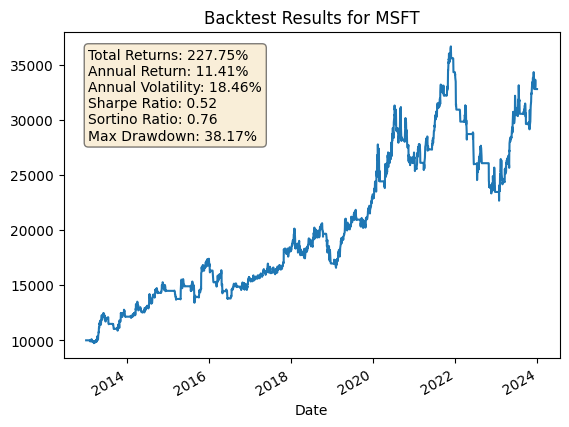

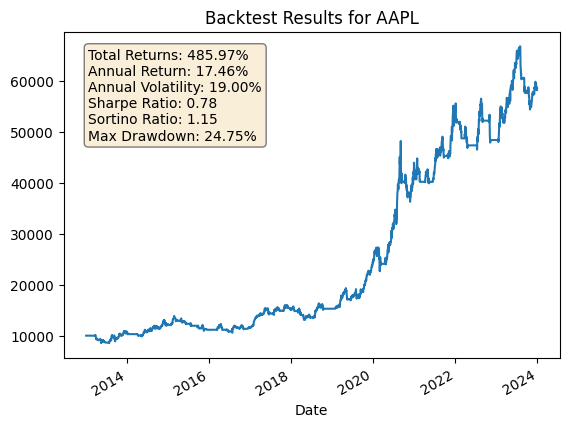

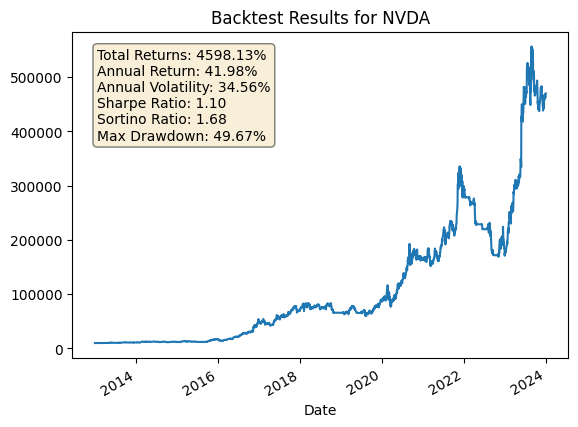

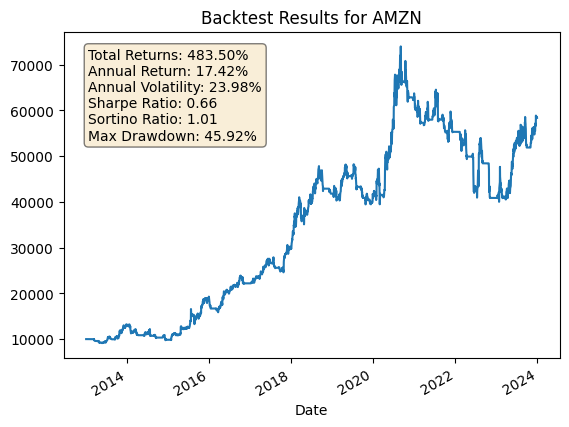

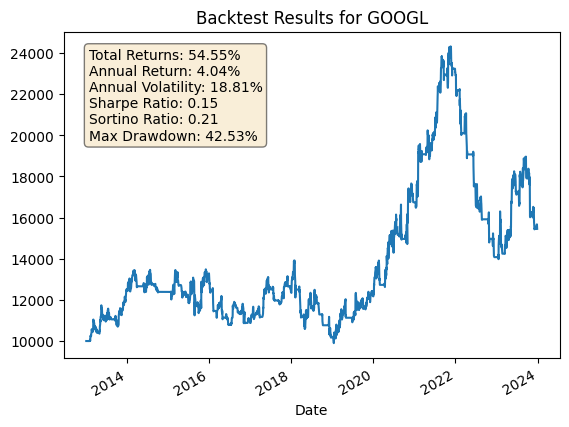

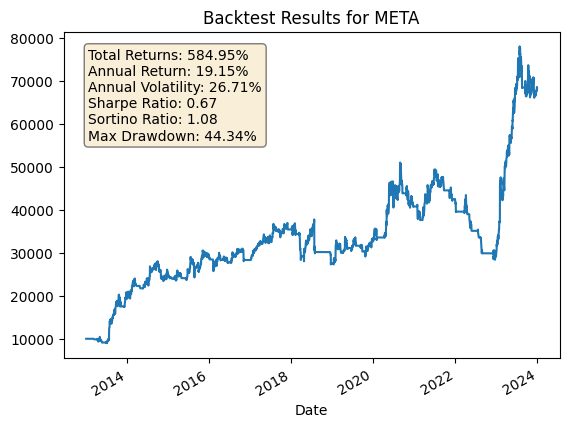

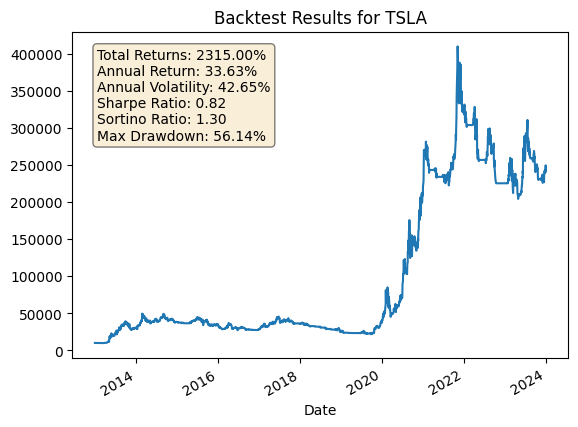

In [8]:
# Example usage:
if __name__ == "__main__":

    tickers = ['MSFT', 'AAPL', 'NVDA', 'AMZN', 'GOOGL', 'META', 'TSLA']
    for ticker in tickers:
        backtester = Backtest(ticker, 10000, '2013-01-01', '2023-12-31')
        backtester.run_strategy(Double_Bollinger_Band_Indicator)
        backtester.calculate_metrics()
        # backtester.print_metrics()
        backtester.plot_results()